# Canopy Height Map in Dak Lak (Viet Nam) based on GEDI, Sentinel-1 and Sentinel-2 data with Convolutional Neural Network Unet Architecture

## 1. Data Preparation

In [1]:
PATCH_SIZE = 256
TILE_SIZE = 1024

In [2]:
import rasterio

# Path to the merged mosaic
mosaic_fp = "/root/Bản sao của DakLak_Full_Merged_Final_Final.tif"

# Open and read the data
with rasterio.open(mosaic_fp) as src:
    mosaic = src.read()  # This reads all bands as a NumPy array
    mosaic_meta = src.meta  # Save metadata if needed

print("Mosaic shape:", mosaic.shape)  # (bands, height, width)


Mosaic shape: (15, 13879, 16445)


In [3]:
import numpy as np
# Compute reasonable thresholds
low_q = np.nanpercentile(mosaic[0], 0.1)
high_q = np.nanpercentile(mosaic[0], 99.9)

print("Low threshold:", low_q)
print("High threshold:", high_q)

Low threshold: 1.8300000429153442
High threshold: 51.675399244795


In [4]:
band0 = mosaic[0].astype(float)
cleaned_band0 = np.where((band0 < low_q) | (band0 > high_q), np.nan, band0)
mosaic[0] = cleaned_band0

In [5]:
band_name = ['rh95', 'VV_ascending', 'VH_ascending', 'VV_descending', 'VH_descending', 
 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B11', 'B12']

In [6]:
import numpy as np

def tile_mosaic(mosaic, tile_size, check_band=1):
    """
    mosaic: numpy array (bands, height, width)
    tile_size: tile size in pixels (int)
    check_band: 0-based index of band to check for NaNs
    """
    bands, height, width = mosaic.shape
    tiles = []
    
    for i in range(0, height, tile_size):
        for j in range(0, width, tile_size):
            # Ensure we stay inside the image
            if i + tile_size > height or j + tile_size > width:
                continue
                
            tile = mosaic[:, i:i+tile_size, j:j+tile_size]
            
            # Check for NaNs in the specified band
            if not np.isnan(tile[check_band]).any():
                tiles.append(tile)
    
    return tiles

# Example usage
tiles = tile_mosaic(mosaic, TILE_SIZE, check_band=1)
print("Number of tiles without NaNs:", len(tiles))


Number of tiles without NaNs: 91


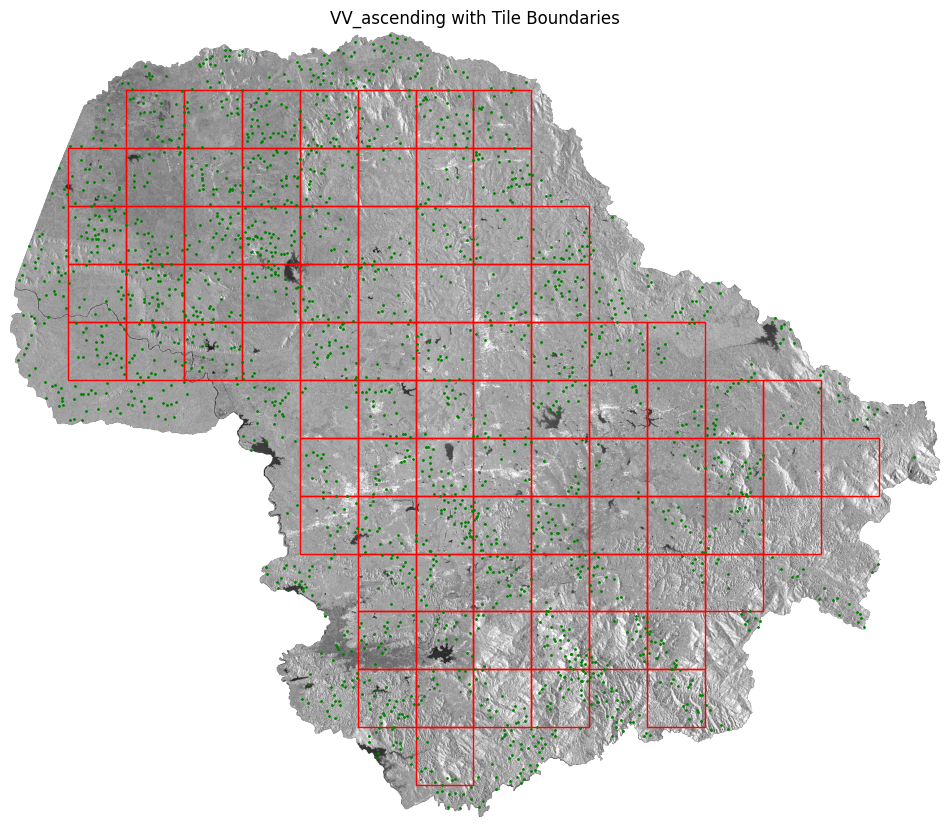

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# Example: use VV_ascending (mosaic[1]) for display
img = mosaic[1]  # shape: height x width
gedi = mosaic[0]

# Downsample for display (to make plotting faster)
scale = 10  # reduce resolution by 10x
img_small = img[::scale, ::scale]
gedi_small = gedi[::scale, ::scale]

# Tile parameters
pixels_per_tile = TILE_SIZE  # 80 km² tile at 10 m/pixel
tile_color = 'red'

# Plot the downsampled image
plt.figure(figsize=(12, 12))
plt.imshow(img_small, cmap='gray')
plt.title("VV_ascending with Tile Boundaries")
plt.axis('off')

# Overlay tiles
height, width = img.shape
for i in range(0, height, pixels_per_tile):
    for j in range(0, width, pixels_per_tile):
        # Check if tile is valid (no NaNs in VV_ascending)
        tile = img[i:i+pixels_per_tile, j:j+pixels_per_tile]
        if not np.isnan(tile).any():
            # Scale coordinates for downsampled image
            rect = Rectangle(
                (j/scale, i/scale),
                pixels_per_tile/scale,
                pixels_per_tile/scale,
                linewidth=1, edgecolor=tile_color, facecolor='none'
            )
            plt.gca().add_patch(rect)

# Overlay GEDI footprints as scatter points
# Only plot pixels where GEDI is valid (non-NaN)
y, x = np.where(~np.isnan(gedi_small))
plt.scatter(x, y, s=1, color='green', label='GEDI footprint')

plt.show()


In [8]:
import numpy as np
from sklearn.model_selection import train_test_split

# has_gedi = True if tile has any GEDI footprint (layer 0)
has_gedi = np.array([np.any(~np.isnan(tile[0])) for tile in tiles])

# Only keep tiles with GEDI for training
tiles_with_gedi = [tile for tile, gedi in zip(tiles, has_gedi) if gedi]

# Split train/test (80/20) among tiles with GEDI
train_idx, test_idx = train_test_split(
    np.arange(len(tiles_with_gedi)),
    test_size=0.2,
    random_state=42
)

tiles_train = [tiles_with_gedi[i] for i in train_idx]
tiles_test = [tiles_with_gedi[i] for i in test_idx]

print("Total tiles with GEDI:", len(tiles_with_gedi))
print("Training tiles:", len(tiles_train))
print("Testing tiles:", len(tiles_test))


Total tiles with GEDI: 91
Training tiles: 72
Testing tiles: 19


In [9]:
all_test_patches = []

for tile in tiles_test:
    C, H, W = tile.shape
    for i in range(0, H, PATCH_SIZE):
        for j in range(0, W, PATCH_SIZE):
            patch = tile[:, i:i+PATCH_SIZE, j:j+PATCH_SIZE]
            all_test_patches.append(patch)

print(f"Total test patches: {len(all_test_patches)}")
print(f"Example patch shape: {all_test_patches[0].shape}")

Total test patches: 304
Example patch shape: (15, 256, 256)


In [26]:
import numpy as np

# Suppose all_test_patches is a list of (15, 256, 256) arrays
all_nan_patches_idx = []

for idx, patch in enumerate(all_test_patches):
    # Check if layer 0 is all NaNs
    if np.all(np.isnan(patch[0])):
        all_nan_patches_idx.append(idx)

print(f"Patches with all NaNs in layer 0: {all_nan_patches_idx}")
print(f"Number of such patches: {len(all_nan_patches_idx)}")
all_test_patches = [patch for idx, patch in enumerate(all_test_patches)
                      if idx not in all_nan_patches_idx]


Patches with all NaNs in layer 0: [9, 10, 13, 14, 15, 25, 30, 34, 98, 113, 114, 118, 145, 149, 150, 152, 153, 157, 159, 162, 172, 201, 205, 206, 208, 209, 210, 212, 213, 214, 215, 217, 218, 219, 220, 221, 222, 223, 228, 232, 233, 234, 235, 236, 237, 238, 241, 242, 246, 247, 251, 273, 278, 289, 293, 294, 297, 298, 299, 302, 303]
Number of such patches: 61


In [28]:
import numpy as np

# Total non-NaN pixels in layer 0 for training tiles
total_train_gedi = sum(np.count_nonzero(~np.isnan(tile[0])) for tile in tiles_train)

# Total non-NaN pixels in layer 0 for testing tiles
total_test_gedi = sum(np.count_nonzero(~np.isnan(tile[0])) for tile in tiles_test)

print("Total non-NaN pixels in layer 0 (train):", total_train_gedi)
print("Total non-NaN pixels in layer 0 (test):", total_test_gedi)


Total non-NaN pixels in layer 0 (train): 114418
Total non-NaN pixels in layer 0 (test): 33361


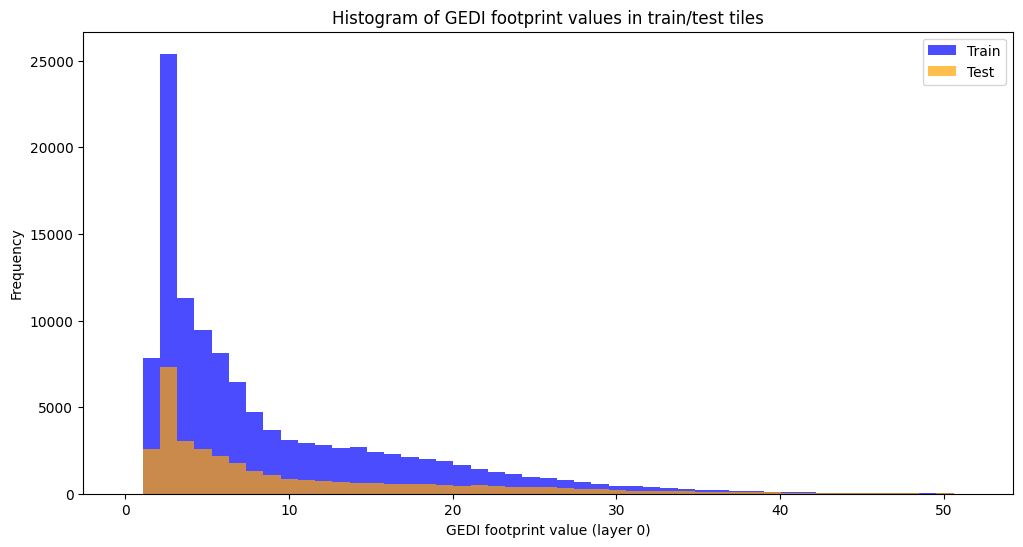

In [29]:
import numpy as np
import matplotlib.pyplot as plt

# Gather all non-NaN GEDI values from train tiles
train_values = np.concatenate([tile[0][~np.isnan(tile[0])] for tile in tiles_train])

# Gather all non-NaN GEDI values from test tiles
test_values = np.concatenate([tile[0][~np.isnan(tile[0])] for tile in tiles_test])

# Plot histogram with bins
bins = np.linspace(0, np.nanmax(mosaic[0]), 50)  # 50 bins from 0 to max height

plt.figure(figsize=(12,6))
plt.hist(train_values, bins=bins, alpha=0.7, label='Train', color='blue')
plt.hist(test_values, bins=bins, alpha=0.7, label='Test', color='orange')
plt.xlabel('GEDI footprint value (layer 0)')
plt.ylabel('Frequency')
plt.title('Histogram of GEDI footprint values in train/test tiles')
plt.legend()
plt.show()


## 2. CNN Unet Architecture Model

In [30]:
import torch
from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Torch version: {torch.__version__}")
print(f"Device: {device}")

Torch version: 2.8.0+cu129
Device: cuda


In [31]:
def double_convolution_down(in_channels, out_channels, p_dropout=0.2):
    conv_op = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )
    return conv_op

def double_convolution_up(in_channels, hidden_channels, out_channels, p_dropout=0.2):
    conv_op = nn.Sequential(
        nn.Conv2d(in_channels, hidden_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(hidden_channels),
        nn.ReLU(inplace=True),
        nn.Conv2d(hidden_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
    )
    return conv_op

def output_convolution(in_channels, hidden_channels, output_channels, p_dropout=0.2):
    conv_op = nn.Sequential(
        nn.Conv2d(in_channels, hidden_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(hidden_channels),
        nn.ReLU(inplace=True),
        nn.Conv2d(hidden_channels, output_channels, kernel_size=1, padding=0)
    )
    return conv_op

class UNet(nn.Module):
    def __init__(self, num_channels, num_classes):
        super(UNet, self).__init__()
        self.max_pool2d = nn.MaxPool2d(kernel_size=2, stride=2)
        # Encoding path
        self.down_convolution_1 = double_convolution_down(num_channels, 64)
        self.down_convolution_2 = double_convolution_down(64, 128)
        self.down_convolution_3 = double_convolution_down(128, 256)
        self.down_convolution_4 = double_convolution_down(256, 512)
        self.down_convolution_5 = double_convolution_down(512, 512)
        # Decoding path.
        self.up_transpose_1 = nn.ConvTranspose2d(
            in_channels=512, out_channels=512,
            kernel_size=2, 
            stride=2)
        self.up_convolution_1 = double_convolution_up(1024, 512, 256)
        self.up_transpose_2 = nn.ConvTranspose2d(
            in_channels=256, out_channels=256,
            kernel_size=2, 
            stride=2)
        self.up_convolution_2 = double_convolution_up(512, 256, 128)
        self.up_transpose_3 = nn.ConvTranspose2d(
            in_channels=128, out_channels=128,
            kernel_size=2, 
            stride=2)
        self.up_convolution_3 = double_convolution_up(256, 128, 64)
        self.up_transpose_4 = nn.ConvTranspose2d(
            in_channels=64, out_channels=64,
            kernel_size=2, 
            stride=2)
        self.up_convolution_4 = output_convolution(128, 64, num_classes)

    def forward(self, x):
        # Encoding
        down_1 = self.down_convolution_1(x)
        down_2 = self.max_pool2d(down_1)
        down_3 = self.down_convolution_2(down_2)
        down_4 = self.max_pool2d(down_3)
        down_5 = self.down_convolution_3(down_4)
        down_6 = self.max_pool2d(down_5)
        down_7 = self.down_convolution_4(down_6)
        down_8 = self.max_pool2d(down_7)
        down_9 = self.down_convolution_5(down_8)        
        # Decoding
        up_1 = self.up_transpose_1(down_9)
        x = self.up_convolution_1(torch.cat([down_7, up_1], 1))
        up_2 = self.up_transpose_2(x)
        x = self.up_convolution_2(torch.cat([down_5, up_2], 1))
        up_3 = self.up_transpose_3(x)
        x = self.up_convolution_3(torch.cat([down_3, up_3], 1))
        up_4 = self.up_transpose_4(x)
        out = self.up_convolution_4(torch.cat([down_1, up_4], 1))
        return out

In [32]:
import torch
import torch.nn as nn

class MaskedMAELoss(nn.Module):
    def forward(self, pred, target):
        # pred and target shapes: [B, 1, H, W]
        mask = ~torch.isnan(target)    
        loss = torch.abs(pred[mask] - target[mask])
        return loss.mean()


In [33]:
import torch

def global_masked_r2(all_preds, all_targets):
    """
    all_preds, all_targets: list of 1D tensors
    """
    y_pred = torch.cat(all_preds)   # shape: [N]
    y_true = torch.cat(all_targets) # shape: [N]

    ss_res = torch.sum((y_true - y_pred) ** 2)
    ss_tot = torch.sum((y_true - torch.mean(y_true)) ** 2)
    
    return 1 - ss_res / (ss_tot + 1e-8)


In [34]:
import torch
from torch.utils.data import Dataset
import numpy as np
import random

class TilePatchDataset(Dataset):
    def __init__(self, tiles, patch_size=256, patches_per_epoch=960):
        self.tiles = tiles
        self.patch_size = patch_size
        self.patches_per_epoch = patches_per_epoch

        # Compute weights proportional to GEDI footprints
        self.weights = np.array([np.sum(~np.isnan(tile[0])) for tile in tiles], dtype=np.float32)
        if self.weights.sum() > 0:
            self.weights /= self.weights.sum()
        else:
            self.weights = np.ones(len(tiles)) / len(tiles)

    def __len__(self):
        return self.patches_per_epoch  # exactly this many patches per epoch

    def __getitem__(self, idx):
        # Weighted random tile selection
        tile_idx = np.random.choice(len(self.tiles), p=self.weights)
        tile = self.tiles[tile_idx]

        C, H, W = tile.shape
        ph = pw = self.patch_size

        # Random patch with at least one GEDI footprint
        for _ in range(50):
            x = random.randint(0, W - pw)
            y = random.randint(0, H - ph)
            gedi_patch = tile[0, y:y+ph, x:x+pw]
            if np.any(~np.isnan(gedi_patch)):
                img_patch = tile[1:, y:y+ph, x:x+pw]  # input features
                break
        else:
            x = (W - pw)//2
            y = (H - ph)//2
            img_patch = tile[1:, y:y+ph, x:x+pw]
            gedi_patch = tile[0, y:y+ph, x:x+pw]

        img_patch = torch.tensor(img_patch, dtype=torch.float32)
        gedi_patch = torch.tensor(gedi_patch, dtype=torch.float32).unsqueeze(0)

        return img_patch, gedi_patch


In [35]:
class TileFullDataset(Dataset):
    def __init__(self, tiles):
        """
        tiles: list of numpy arrays [C,H,W]
               layer 0 = GEDI (label)
               layer 1.. = input features
        """
        self.tiles = tiles

    def __len__(self):
        return len(self.tiles)

    def __getitem__(self, idx):
        tile = self.tiles[idx]

        img = tile[1:]                         # inputs
        gedi = tile[0:1]                       # label (keep channel dim)

        img = torch.tensor(img, dtype=torch.float32)
        gedi = torch.tensor(gedi, dtype=torch.float32)

        return img, gedi


In [36]:
from torch.utils.data import DataLoader

patch_size = PATCH_SIZE
batch_size = 32

train_dataset = TilePatchDataset(tiles_train, patch_size=patch_size)
test_dataset  = TileFullDataset(all_test_patches)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=1, shuffle=False)


In [37]:
import torch.optim as optim

model = UNet(num_channels=14, num_classes=1).to(device)
model = nn.DataParallel(model).to(device)
criterion = MaskedMAELoss()

optimizer = optim.Adam(model.parameters(), lr=1e-5)
# 'triangular2' scheduler from torch.optim.lr_scheduler
scheduler = optim.lr_scheduler.CyclicLR(
    optimizer,
    base_lr=1e-5,
    max_lr=1e-3,
    step_size_up=320,  # half cycle
    mode='triangular2'
)

num_epochs = 200

for epoch in range(num_epochs):
    # --- Training ---
    model.train()
    running_loss = 0.0

    for imgs, gedi in train_loader:
        imgs = imgs.to(device)
        gedi = gedi.to(device)

        optimizer.zero_grad()
        preds = model(imgs)
        loss = criterion(preds, gedi)
        loss.backward()
        optimizer.step()
        scheduler.step()
        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)

    # --- Testing / Validation ---
    model.eval()
    all_preds = []
    all_targets = []
    running_r2 = 0.0
    test_loss = 0.0
    with torch.inference_mode():
        for imgs, gedi in test_loader:
            imgs = imgs.to(device)
            gedi = gedi.to(device)

            preds = model(imgs)
            loss = criterion(preds, gedi)

            mask = ~torch.isnan(gedi)
            y_true = gedi[mask].detach().cpu()
            y_pred = preds[mask].detach().cpu()
            all_targets.append(y_true)
            all_preds.append(y_pred)

            test_loss += loss.item()

    global_r2 = global_masked_r2(all_preds, all_targets)
    test_loss /= len(test_loader)

    print(f"Epoch {epoch+1}/{num_epochs} | Train MAE: {train_loss:.4f} | Test MAE: {test_loss:.4f} | Test R2: {global_r2:.4f}")



Epoch 1/200 | Train MAE: 10.0548 | Test MAE: 8.7991 | Test R2: -1.0671
Epoch 2/200 | Train MAE: 9.4577 | Test MAE: 8.4650 | Test R2: -1.0006
Epoch 3/200 | Train MAE: 8.4311 | Test MAE: 8.2551 | Test R2: -0.9683
Epoch 4/200 | Train MAE: 9.2393 | Test MAE: 7.5628 | Test R2: -0.8001
Epoch 5/200 | Train MAE: 8.0581 | Test MAE: 8.1202 | Test R2: -0.8818
Epoch 6/200 | Train MAE: 7.5375 | Test MAE: 7.7672 | Test R2: -0.9460
Epoch 7/200 | Train MAE: 7.1091 | Test MAE: 8.8182 | Test R2: -1.0639
Epoch 8/200 | Train MAE: 7.7495 | Test MAE: 5.5032 | Test R2: 0.0960
Epoch 9/200 | Train MAE: 6.0598 | Test MAE: 7.8216 | Test R2: -1.3262
Epoch 10/200 | Train MAE: 5.9265 | Test MAE: 15.1519 | Test R2: -2.4637
Epoch 11/200 | Train MAE: 4.9741 | Test MAE: 5.8526 | Test R2: 0.1667
Epoch 12/200 | Train MAE: 4.7619 | Test MAE: 4.9303 | Test R2: 0.2302
Epoch 13/200 | Train MAE: 4.3017 | Test MAE: 3.9256 | Test R2: 0.4406
Epoch 14/200 | Train MAE: 3.9602 | Test MAE: 4.2272 | Test R2: 0.3541
Epoch 15/200 | Tra